In [1]:
import os
import pandas as pd
import numpy
import seaborn as sns
import cv2
import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from skimage.feature import hog
from sklearn.decomposition import PCA

In [2]:
main_dir_train = 'train'

train_image_path = []
train_labels = []

train_label_folders = os.listdir(main_dir_train)
for folder in train_label_folders:
    folder_path = os.path.join(main_dir_train,folder)
    files = os.listdir(folder_path)
    for image in files:
        image_path = os.path.join(folder_path,image)
        train_image_path.append(image_path)
        train_labels.append(folder)

tr_df = pd.DataFrame(data={'file_path':train_image_path,'label':train_labels})
tr_df.head()

,file_path,label
0,train\american_football\american_football_0.jpg,american_football
1,train\american_football\american_football_1.jpg,american_football
2,train\american_football\american_football_10.jpg,american_football
3,train\american_football\american_football_101.jpg,american_football
4,train\american_football\american_football_102.jpg,american_football


In [3]:
main_dir_test = 'test'

test_image_path = []
test_labels = []

test_label_folders = os.listdir(main_dir_test)
for folder in test_label_folders:
    folder_path = os.path.join(main_dir_test,folder)
    files = os.listdir(folder_path)
    for image in files:
        image_path = os.path.join(folder_path,image)
        test_image_path.append(image_path)
        test_labels.append(folder)

ts_df = pd.DataFrame(data={'file_path':train_image_path,'label':train_labels})
ts_df.head()

,file_path,label
0,train\american_football\american_football_0.jpg,american_football
1,train\american_football\american_football_1.jpg,american_football
2,train\american_football\american_football_10.jpg,american_football
3,train\american_football\american_football_101.jpg,american_football
4,train\american_football\american_football_102.jpg,american_football


In [4]:
tr_df

,file_path,label
0,train\american_football\american_football_0.jpg,american_football
1,train\american_football\american_football_1.jpg,american_football
2,train\american_football\american_football_10.jpg,american_football
3,train\american_football\american_football_101.jpg,american_football
4,train\american_football\american_football_102.jpg,american_football
...,...,...
3872,train\volleyball\volleyball_95.jpg,volleyball
3873,train\volleyball\volleyball_96.jpg,volleyball
3874,train\volleyball\volleyball_97.jpg,volleyball
3875,train\volleyball\volleyball_98.jpg,volleyball


In [5]:
def preprocess_image(image):
    # Resize
    image = cv2.resize(image, (64, 64))
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Normalize
    normalized = gray / 255.0
    # Gaussian blur
    blurred = cv2.GaussianBlur(normalized, (3, 3), 0) #3×3 grid
    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply((blurred * 255).astype(np.uint8))
    return enhanced

In [12]:
def segmentain_ball(image):
    # Thresholding
    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Morphological operations
    kernel = np.ones((5, 5), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    # Find contours
    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        segmented_ball = image[y:y+h, x:x+w]
        return segmented_ball
    return image

In [13]:

def extract_hog_features(images, target_size=(64, 64)):
    hog_features = []
    for img in images:
        # 1. Convert to grayscale if needed
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # 2. Resize to fixed dimensions
        img = cv2.resize(img, target_size)
        
        # 3. Compute HOG features
        features = hog(
            img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=False,
            channel_axis=None
        )
        hog_features.append(features)
    
    return np.array(hog_features)


In [ ]:
def load_data(tr_df, ts_df):
    # Load images from file paths (replace with your actual image loading logic)
    X_train = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in tr_df["file_path"]]
    X_test = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in ts_df["file_path"]]
    y_train = tr_df["label"]
    y_test = ts_df["label"]
    return X_train, X_test, y_train, y_test

# Load data
X_train, X_test, y_train, y_test = load_data(tr_df, ts_df)

#apply preprocessing and segmentation
X_train = [preprocess_image(cv2.imread(path)) for path in tr_df["file_path"]]
X_test = [preprocess_image(cv2.imread(path)) for path in ts_df["file_path"]]
X_train = [segmentain_ball(img) for img in X_train]
X_test = [segmentain_ball(img) for img in X_test]

X_train_hog = extract_hog_features(X_train)  # Shape: (n_train, 1764)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_hog)

# Testing
X_test_hog = extract_hog_features(X_test)     # Shape: (n_test, 1764)
X_test_pca = pca.transform(X_test_hog)





In [15]:
# Define the model
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

param_grid = {'C': [0.1, 1], 'gamma': [0.01, 0.1, 1]}
svm = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)
svm.fit(X_train_pca, y_train)

print("Best parameters:", svm.best_params_)
y_pred = svm.predict(X_test_pca)

Best parameters: {'C': 1, 'gamma': 0.1}


Accuracy: 0.9868454990972402
                   precision    recall  f1-score   support

american_football       1.00      1.00      1.00       384
         baseball       0.99      0.99      0.99       400
       basketball       1.00      0.96      0.98       340
    billiard_ball       0.98      0.99      0.99       646
     cricket_ball       0.98      0.99      0.99       581
         football       0.97      1.00      0.99       604
      tennis_ball       0.99      0.97      0.98       490
       volleyball       1.00      0.98      0.99       432

         accuracy                           0.99      3877
        macro avg       0.99      0.99      0.99      3877
     weighted avg       0.99      0.99      0.99      3877



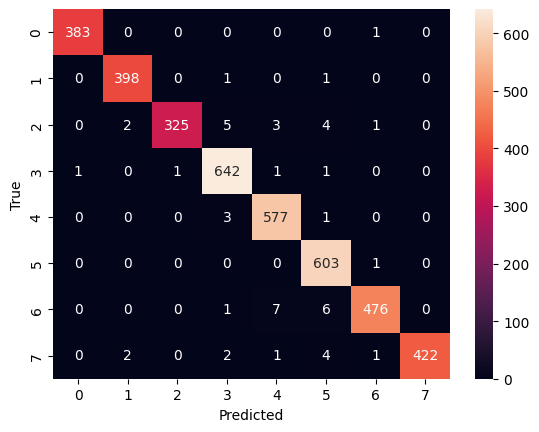

In [16]:
# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [17]:
#save the model
import joblib
joblib.dump(svm, 'svm_model.pkl')


['svm_model.pkl']